# Data Analysis of the PeTaL Labeled Dataset

# Author(s)
- Author1 = {"name": "David Smith", "affiliation": "NASA GRC", "email": "dacasm@umich.edu"}

# Purpose
The purpose of this notebook is to explore our labeled dataset and reveal any information which will help us improve the dataset and potentially increase the accuracy of our NLP labelers.

# Results

## 07-01-2021
8% of our unique labels account for 27.29% of the total amount of labels used. Additionally 26% of our unique labels are used less than 10 times. Some of the best practices dictated from organizations such as Google are:
- A dataset should have at least 10 examples of a label to ensure the model is able to learn it.
- Labels should have a similar number of examples to prevent the model from overfitting.

### Suggested Next Steps
It may help our model short-term to remove underused labels and to trim overused labels. The better solution is to balance out our dataset by increasing the amount of examples representing the underused labels and to simply have more data.

# Setup

## Library Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

# Data Processing and Analysis

## Reformat Data

Convert data in to Pandas dataframes.

In [16]:
url = 'https://raw.githubusercontent.com/nasa-petal/petal-labeler-data-pipeline/master/FinalFile/golden.json'
df = pd.read_json(url, orient='columns')
df.fillna('[]', inplace = True)

In [17]:
# remap level1 labels
df.level1 = df.level1.replace({'physically_assemble/disassemble' : 'physically_assemble_or_disassemble',
                               'sense,_send,_or_process_information': 'sense_send_or_process_information',
                               'maintain_ecological_community':'sustain_ecological_community',
                               'manipulate_solids,_liquids,_gases,_or_energy':'manipulate_solids_liquids_gases_or_energy'}, regex=True)

# remove rows with no level1 labels, no paper ids, or no titles
df = df[df['level1'] != '[]']
df = df[df['level1'] != "['']"]
df = df[df['paper'] != '']
df = df[df['title'] != '']
df = df[df['title'] != '[]']
df = df[df['title'] != "['']"]
df

# convert level1 array strings to actual arrays
from ast import literal_eval
df['level1'] = df['level1'].apply(literal_eval)

Pull all level I labels into a flat list.

In [18]:
taxonomy_labels = ['protect_from_harm', 'physically_assemble_or_disassemble', 'chemically_modify_or_change_energy_state', 'attach', 'change_size_or_color', 'process_resources', 'move', 'sense_send_or_process_information', 'maintain_structural_integrity', 'sustain_ecological_community']

Create object which will contain additionally mined data.

In [19]:
analysis_object = {}
label_info = {
    "Absolute Label Frequency": {},
    "Relative Label Frequency": {}
}

Mine data to find:
- Absolute Label Frequency
- Relative Label Frequency
- Total Number of Labels
- Number of Words in Each Label

In [21]:
# Iterate through each row within our csv

for index, row in df.iterrows():

    # Look through each label and increment label counter if found
    for label in row['level1']:
        if (label in taxonomy_labels):
            label_count = label_info["Absolute Label Frequency"].get(label, 0)
            label_info["Absolute Label Frequency"][label] = label_count + 1

# Compute Total Number of Labels and Relative Label Frequency
label_info["Total Number of Labels"] = sum(label_info["Absolute Label Frequency"].values())

for label in label_info["Absolute Label Frequency"].keys():
    label_info["Relative Label Frequency"][label] = round((label_info["Absolute Label Frequency"][label] / label_info["Total Number of Labels"]), 4) * 100


Convert object into dataframe

In [22]:
# Drop Total Number of Labels as it is an aggregate value.
label_dataframe = pd.DataFrame(label_info).drop("Total Number of Labels", axis = 1)

# Count and store the amount of words in each label
label_dataframe["Label Length"] = label_dataframe.index.map(lambda label: len(re.split("\W", label)))

## Visualization and Metrics

Frequency of Absolute Label Counts histogram depicts the count of the frequencies of labels used (e.x. A frequency of 40 and a range of 0-25 means that 40 unique labels were used between 0 and 25 times).

Text(0.5, 0, 'Label Counts')

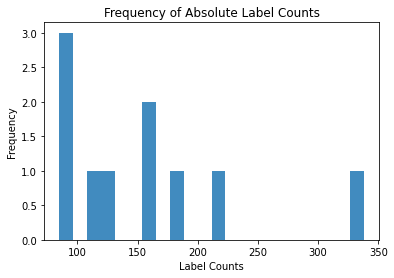

In [23]:
# Plot a histogram depicting the counts of frequencies of labels used.
fig = label_dataframe["Absolute Label Frequency"].plot.hist(bins = 22, alpha=0.85, title = "Frequency of Absolute Label Counts")
plt.xlabel("Label Counts")

Frequency of Labels bar chart depicts the number of times each label appears within the dataset. It also displays the 25%, 50% and 75 quantiles (q1, q2, q3) and shows the average magnitude of each bar.

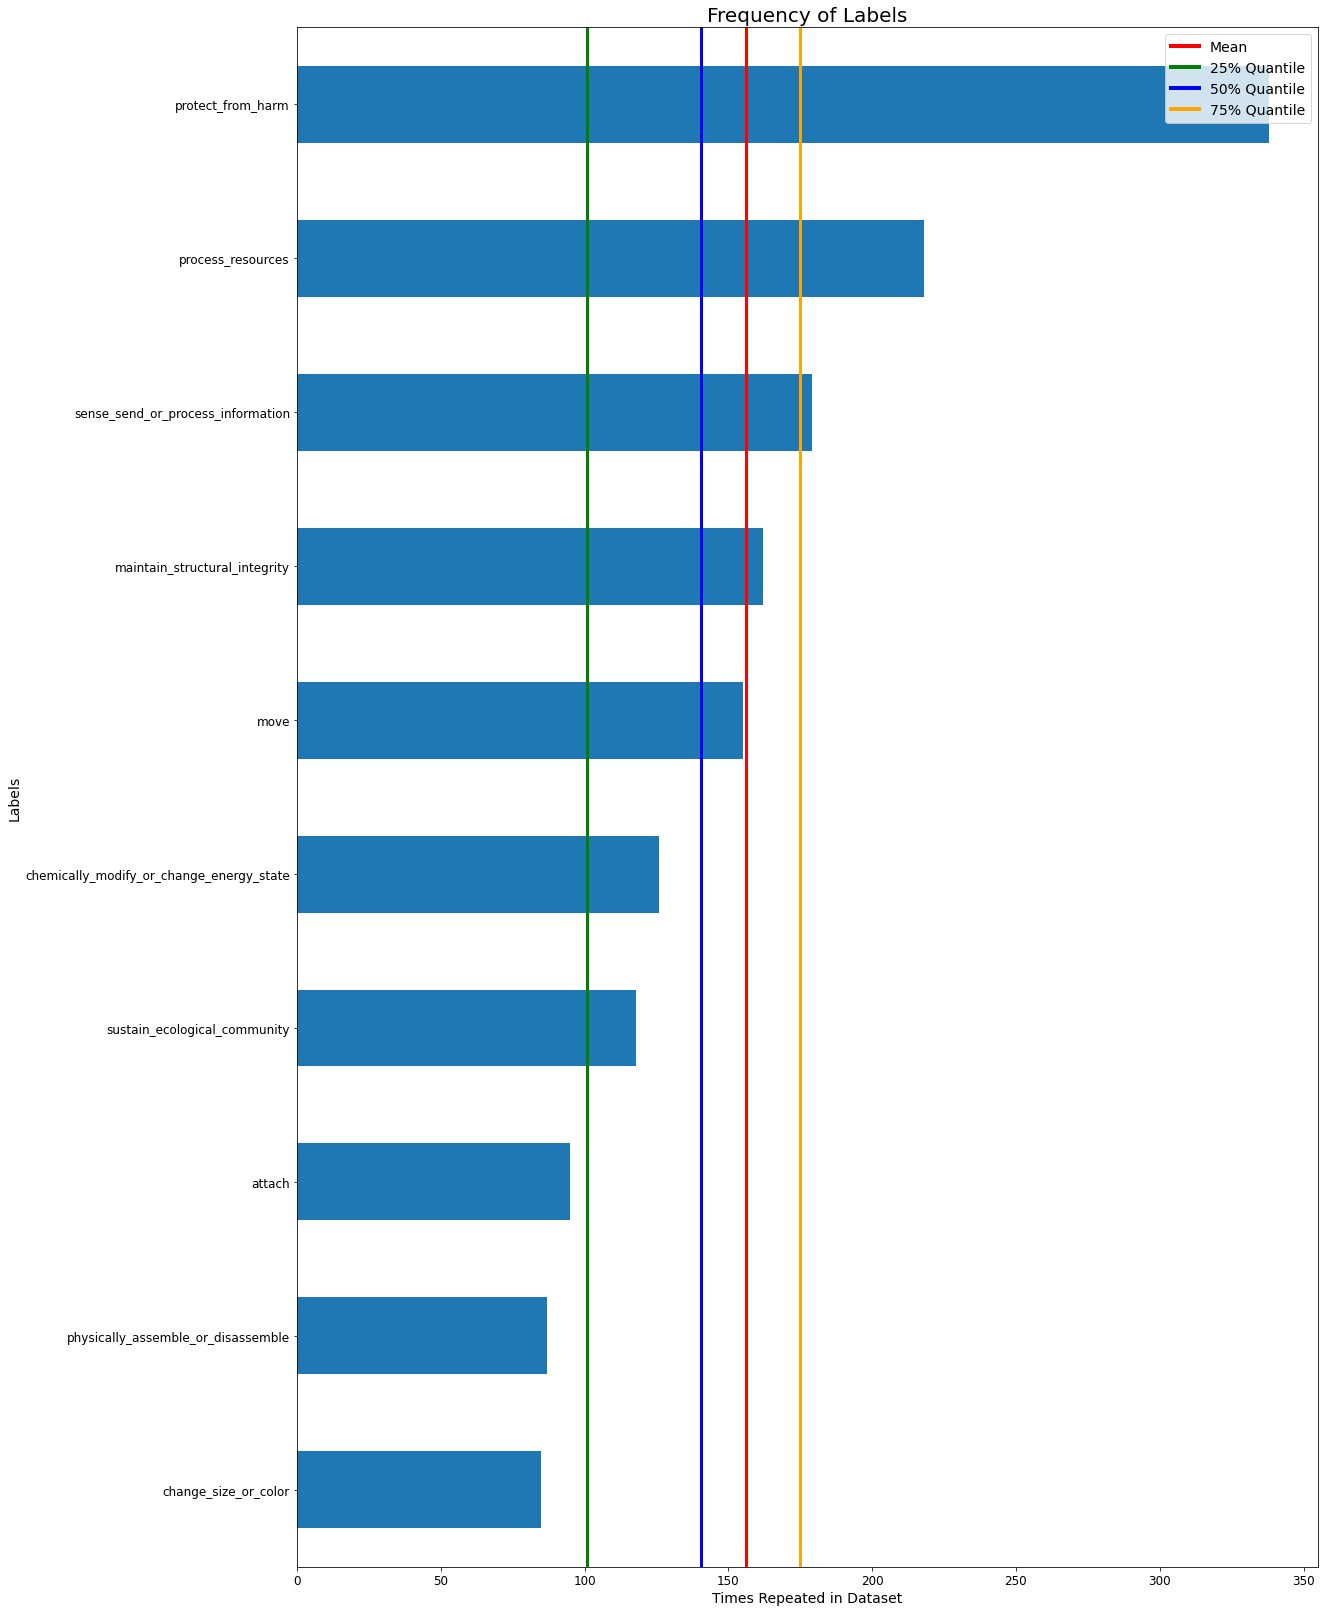

In [25]:
fig = label_dataframe["Absolute Label Frequency"].sort_values().plot.barh(width=0.5, fontsize=12)
label_quantiles = label_dataframe["Absolute Label Frequency"].quantile([0.25, 0.5, 0.75])
fig.axvline(label_dataframe["Absolute Label Frequency"].mean(), color="red", linewidth=3)
fig.axvline(label_quantiles[0.25], color="g", linewidth=3)
fig.axvline(label_quantiles[0.5], color="b", linewidth=3)
fig.axvline(label_quantiles[0.75], color="orange", linewidth=3)

legend_elements = [plt.Line2D([0], [0], color='r', lw=4, label='Mean'),
                     plt.Line2D([0], [0], color='g', lw=4, label='25% Quantile'),
                     plt.Line2D([0], [0], color='b', lw=4, label='50% Quantile'),
                     plt.Line2D([0], [0], color='orange', lw=4, label='75% Quantile')]

plt.legend(handles=legend_elements, loc='upper right', fontsize=14)
plt.gcf().set_size_inches(18.5, 22.5)
plt.ylabel("Labels", fontsize=14)
plt.xlabel("Times Repeated in Dataset", fontsize=14)
plt.title("Frequency of Labels", fontsize=20)
plt.tight_layout()

# Save Figure
fig.figure.patch.set_facecolor('#FFF')
#plt.savefig("./freq_of_label_counts.png", edgecolor="black")

plt.show()

In [26]:
# Compare the number of unique labels and their total relative percentage between the upper and lower data in terms of usage.
upper_half_label_dataframe = label_dataframe["Absolute Label Frequency"][
    label_dataframe["Absolute Label Frequency"] > 50]
lower_half_label_dataframe = label_dataframe["Absolute Label Frequency"][
    label_dataframe["Absolute Label Frequency"] <= 50]
low_rep_label_dataframe = label_dataframe["Absolute Label Frequency"][
    label_dataframe["Absolute Label Frequency"] < 10]

print("Total number of unique labels (will be known as x): {}".format(len(taxonomy_labels)))
print("Total number of used labels (will be known as y): {}".format(
    label_info["Total Number of Labels"]))

print("\nCount of unique labels used more than 50 times: {}".format(
    upper_half_label_dataframe.shape[0]))
print("Total count of labels used more than 50 times (will be known as a): {}".format(
    upper_half_label_dataframe.sum()))
print("a/y =  {:0.2%}".format(
    upper_half_label_dataframe.sum() / label_info['Total Number of Labels']))

print("\nCount of unique labels used less than or equal to 50 times: {}".format(
    lower_half_label_dataframe.shape[0]))
print("Total count of labels used less than 50 times (will be known as b): {}".format(
    lower_half_label_dataframe.sum()))
print("b/y = {:0.2%}".format(
    lower_half_label_dataframe.sum() / label_info['Total Number of Labels']))

print("\nCount of unique labels used less than 10 times (will be known as c): {}".format(
    low_rep_label_dataframe.shape[0]))
print("c/x = {:0.2%}".format(
    low_rep_label_dataframe.shape[0] / len(taxonomy_labels)))


Total number of unique labels (will be known as x): 10
Total number of used labels (will be known as y): 1563

Count of unique labels used more than 50 times: 10
Total count of labels used more than 50 times (will be known as a): 1563
a/y =  100.00%

Count of unique labels used less than or equal to 50 times: 0
Total count of labels used less than 50 times (will be known as b): 0
b/y = 0.00%

Count of unique labels used less than 10 times (will be known as c): 0
c/x = 0.00%


## Save Data

In [ ]:
label_dataframe.to_csv("./label_metrics.csv")

# References
- https://cloud.google.com/natural-language/automl/docs/beginners-guide#include-enough-labeled-examples-in-each-category
    - Google document dictating the best practices in NLP.